# Initialization

In [2]:
# Import the class to read the file galaxies.hdf5
from GalformRun_basic import * 
import pandas as pd

%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})

import time
import eagleSqlTools as egl
con = egl.connect(user="giorgio",password='BN401kmd') 

In [3]:
# Create an instance of the class GalformRun 
# in order to use functins like .get() and .magnitude()
g = GalformRun('/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/')

In [4]:
# example of how to get the rest-frame V magnitude 
g.magnitude("V_r",1.1734,extinction=True)

array([-16.33772 , -18.87405 , -14.796329, ..., -11.372037, -12.46811 ,
       -13.917074], dtype=float32)

# VIOLETTA ALL GALAXIES

# Download from VIRGO snaps 37 and 47 and save into txt files in COSMA

## Snapshot = 37

In [30]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=37'

t1 = time.time()
ALL_GALAXIES_37 = egl.execute_query(con,Q)
t2 = time.time()

In [48]:
print(t2-t1," seconds")

301.9414653778076  seconds


In [45]:
ALL37 = pd.DataFrame(ALL_GALAXIES_37)

In [46]:
ALL37.to_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ')

## Snapshot = 47

In [49]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=47'

t1 = time.time()
ALL_GALAXIES_47 = egl.execute_query(con,Q)
t2 = time.time()
print(t2-t1," seconds")

317.3331735134125  seconds


In [50]:
ALL47 = pd.DataFrame(ALL_GALAXIES_47)

In [51]:
t1 = time.time()
ALL47.to_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ')
t2 = time.time()
print(t2-t1," seconds")

173.4451880455017  seconds


# Read from txt file 

In [7]:
ALL37 = pd.read_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
ALL47 = pd.read_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Check Plot: Luminosity function Violetta

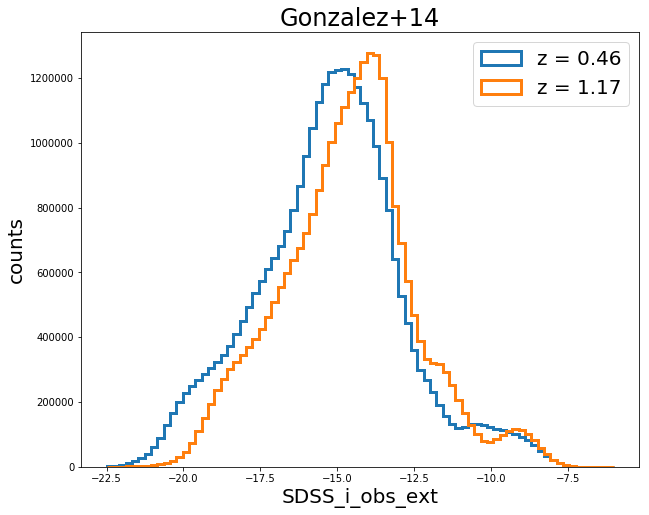

In [11]:
plt.figure(figsize=(10,8))
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Gonzalez+14')
plt.legend()
plt.savefig('./plots/Violetta_luminosity_function.png')
plt.show()

# COSMOLOGY

In [12]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [13]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# Write output in txt files (you don't want to do it again)

In [18]:
def Create_data(volume=0,snap=37,zsnap=1.1734,feedback=True):
    '''Function to read the output of Galform and write it in a txt file in the folder ./txt_data'''
    #create right path
    if feedback: 
        fb = 'gp14'
        fb_save = 'feedback'
    else: 
        fb = 'gp14.nofeedback'
        fb_save= 'nofeedback'
        
    path = '/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/'+fb+'/iz'+str(snap)+'/ivol'+str(volume)+'/'
    #path= '../data/uvi'+str(snap)+'_'+fb+'_vol'+str(volume)+'.txt'
    print(path)
    #read data from galaxies.hdf5 using the class GalformRun
    G = GalformRun(path)
    #u = np.array(G.get("mag_SDSS-u_r_tot_ext",1.1734))
    u = np.array(G.magnitude("SDSS-u_r",zsnap,extinction=True))
    #v = np.array(G.get("mag_V_r_tot_ext",zsnap))
    v = np.array(G.magnitude("V_r",zsnap,extinction=True))
    #i = np.array(G.get("mag_SDSS-i_o_tot_ext",zsnap))
    i = np.array(G.magnitude("SDSS-i_o",zsnap))
    #crete pandas dataframe with data
    df = pd.DataFrame(data={'u':u , 'v':v , 'i':i})
    #save dataframe in a txt file
    df.to_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(volume)+'.txt',index=None,sep=' ')
    return u,v,i

In [56]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol9/


In [58]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol9/


In [59]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol9/


In [62]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol9/


# Read from txt and add subvolumes

In [14]:
def Add_subvolumes(snap=47,feedback=False):
    '''Read all the subvolumes (0 to 9) for the specified snapshot and for the specified AGN feedback scenario'''
    u_tot = []
    v_tot = []
    i_tot = []
    for i_vol in range(10):
        
        if feedback: 
            fb_save = 'feedback'
        else: 
            fb_save= 'nofeedback'
        
        data = pd.read_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(i_vol)+'.txt',delimiter=' ')
        #print(data['u'][0])

        
        u_tot = np.concatenate((u_tot,data['u']))
        v_tot = np.concatenate((v_tot,data['v']))
        i_tot = np.concatenate((i_tot,data['i']))

        
        print(len(u_tot))
        
    return u_tot,v_tot,i_tot

In [15]:
u47_tot_feed, v47_tot_feed, i47_tot_feed = Add_subvolumes(snap=47,feedback=True)

444878
900149
1346992
1798164
2257506
2698382
3157117
3608891
4055006
4497868


In [16]:
u37_tot_feed, v37_tot_feed, i37_tot_feed = Add_subvolumes(snap=37,feedback=True)

411714
833680
1246479
1664890
2091306
2498490
2925176
3344178
3756543
4166102


In [17]:
u47_tot_nofeed, v47_tot_nofeed, i47_tot_nofeed = Add_subvolumes(snap=47,feedback=False)

444878
900149
1346993
1798165
2257507
2698383
3157117
3608891
4055006
4497868


In [18]:
u37_tot_nofeed, v37_tot_nofeed, i37_tot_nofeed = Add_subvolumes(snap=37,feedback=False)

411714
833680
1246480
1664891
2091307
2498491
2925176
3344178
3756543
4166102


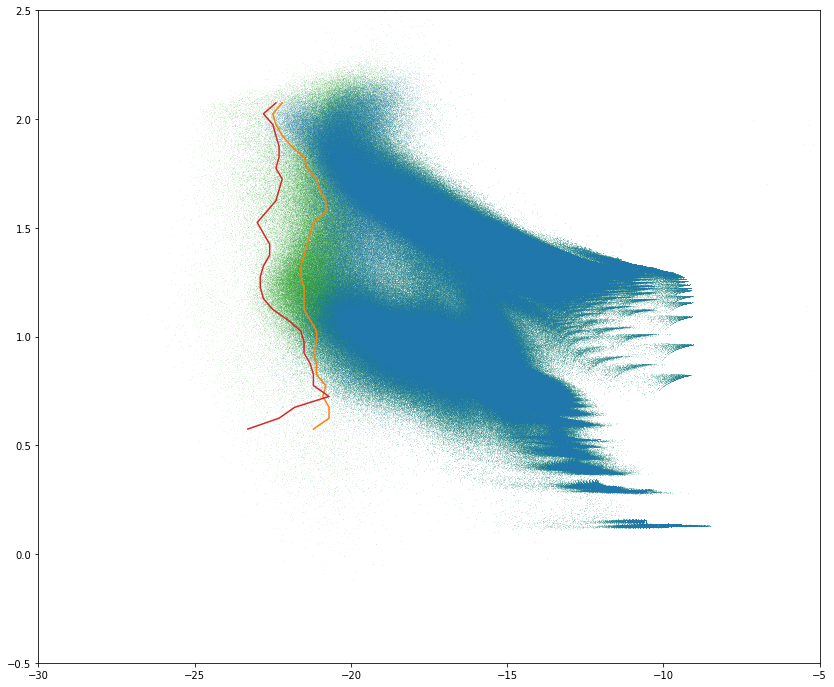

In [19]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

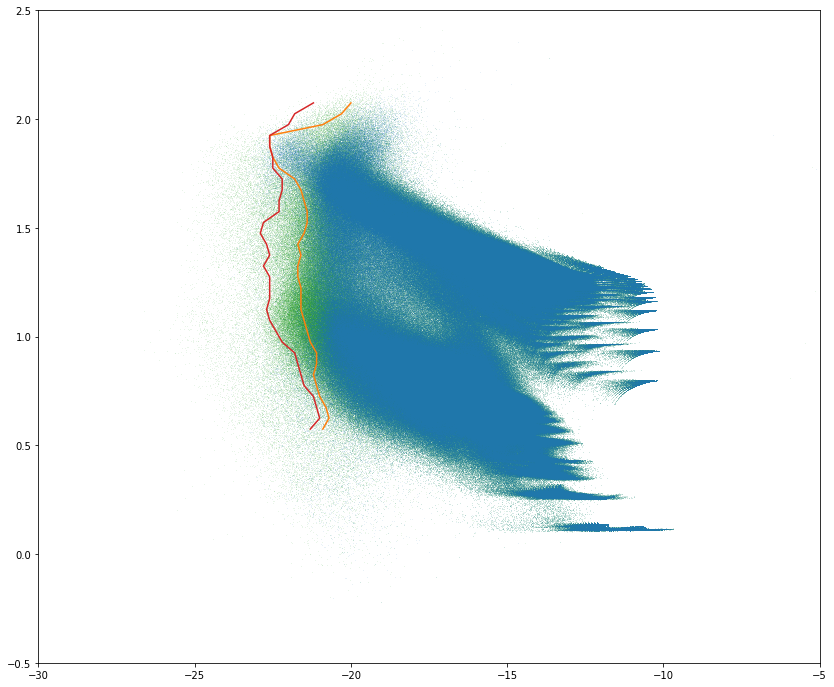

In [20]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

# Cut at 22.5

In [31]:
print('i_AB =22.5 means I_AB of:')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734),' @ z = 1.17')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.465),' @ z = 0.46')

i_AB =22.5 means I_AB of:
-21.256565734819656  @ z = 1.17
-18.79942677774084  @ z = 0.46


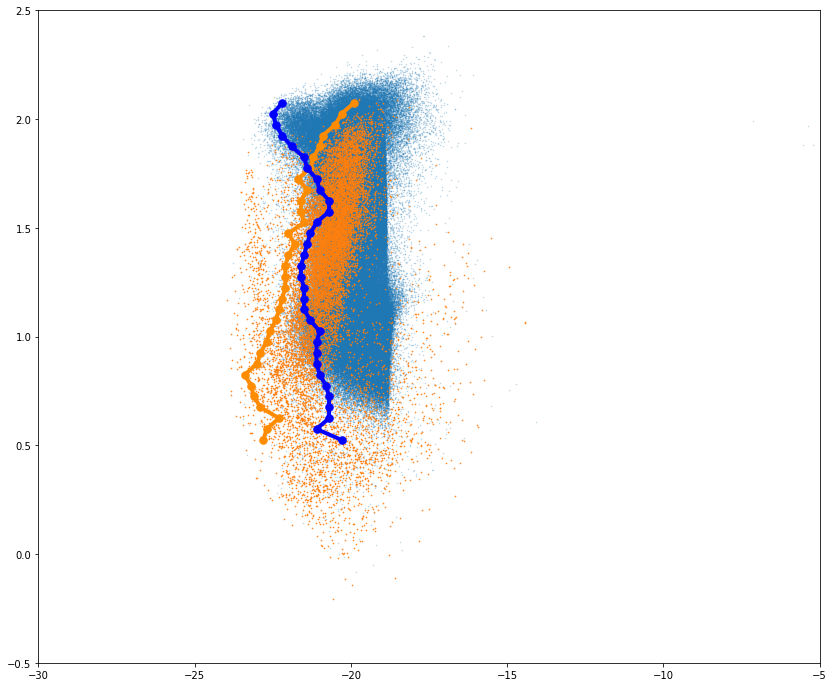

In [62]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
plt.plot(EDGE(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[0],
         EDGE(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[1],
        lw=4,color='darkorange')
plt.plot(EDGE(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[0],
         EDGE(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[1],
        ".",markersize=15,color='darkorange')


sec47 = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.465))
plt.plot(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],".",alpha=1.3,zorder=-1,color='C0',markersize=1.)
plt.plot(EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[0],
         EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[1],
        lw=4,color='blue')
plt.plot(EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[0],
         EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_min=0.5,y_bin_size=0.05,x_max=-15,threashold=0.1)[1],
        ".",markersize=15,color='blue')



##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
#plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.1,zorder=-1)
#plt.plot(EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
#         EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

In [19]:
print(len(v47_tot_feed))

4497868


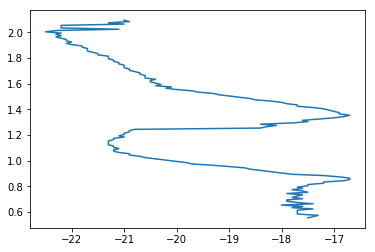

In [104]:
x,y = EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.01)

plt.plot(x,y)
plt.show()

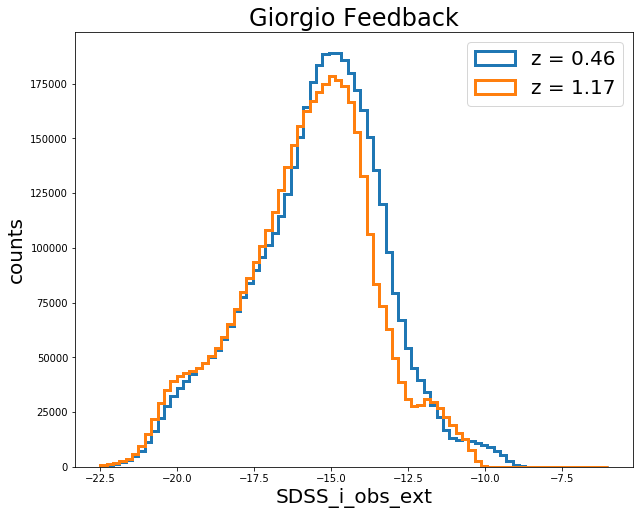

In [82]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/Giorgio_luminosity_function.png')
plt.show()

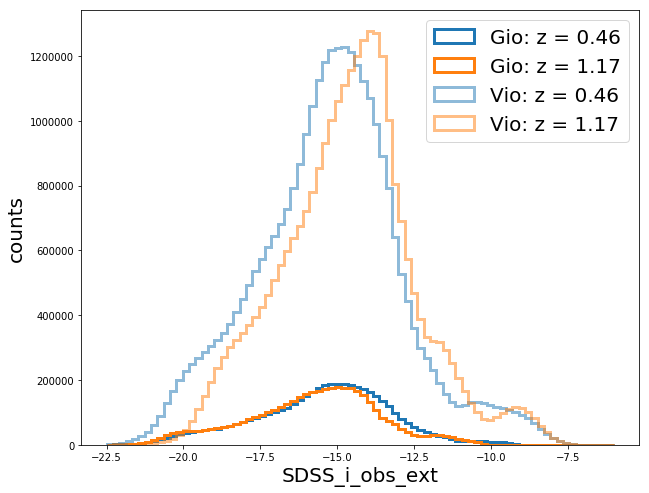

In [83]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Gio: z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Gio: z = 1.17')
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Vio: z = 0.46',alpha=0.5)
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Vio: z = 1.17',alpha=0.5)
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
#plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/i_band_luminosity_function.png')
plt.show()

# Violetta Colour-magnitude against mine

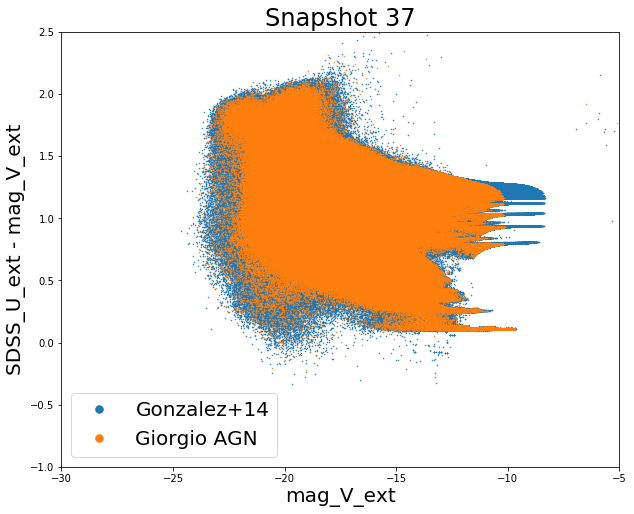

In [86]:
plt.figure(figsize=(10,8))
plt.plot(ALL37['mag_V_ext'],ALL37['SDSS_u_ext']-ALL37['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 37')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
plt.savefig('./plots/colmag37_comparison.png')
plt.show()

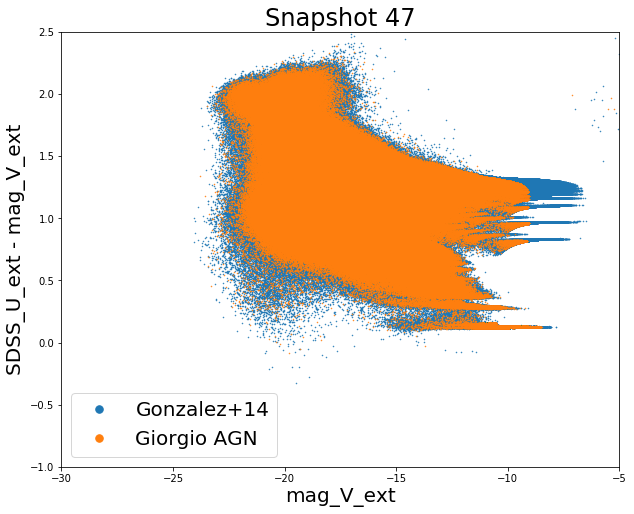

In [87]:
plt.figure(figsize=(10,8))
plt.plot(ALL47['mag_V_ext'],ALL47['SDSS_u_ext']-ALL47['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 47')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
plt.savefig('./plots/colmag47_comparison.png')
plt.show()

# Try cut 22.5 on both

In [ ]:
sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

#are they all numpy arrays